## Carbon budget 
From first principles

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

#import functions_py.modp as mp
#import fates_xarray_functions as fa

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

import functions_py.fates_xarray_functions as fa

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# this function takes data that has monthly values and returns a single annual value, with 
# a mean that accounts for the number of days per month
def monthly_to_annual(array):
    """ calculate annual mean from monthly data, using unequal month lengths for noleap calendar.  
    originally written by Keith Lindsay."""
    mon_day  = xr.DataArray(np.array([31.,28.,31.,30.,31.,30.,31.,31.,30.,31.,30.,31.]), dims=['month'])
    mon_wgt  = mon_day/mon_day.sum()
    return (array.rolling(time=12, center=False) # rolling
            .construct("month") # construct the array
            .isel(time=slice(11, None, 12)) # slice so that the first element is [1..12], second is [13..24]
            .dot(mon_wgt, dims=["month"]))

In [3]:
ninst=7

fates_runs = []

for i in range(1,ninst+1):
    fates_tmp = '/pscratch/sd/j/jneedham/elm_runs/dben/sims2024/fi_p0_{0}.E318d6124be-F6215f5bd.2024-06-06/run/fi_p0_{0}.E318d6124be-F6215f5bd.2024-06-06.sofar.nc'.format(i)
    fates_runs.append(xr.open_dataset(fates_tmp, decode_times=False))


In [4]:
nyears = int(len(fates_runs[0].variables['time'])/12)
tave_start = (nyears-5)
tave_stop = nyears

cohort_size_bins = fates_runs[0].variables['fates_levscls']
patch_age_bins = fates_runs[0].variables['fates_levage'][:]
nsizebins = len(cohort_size_bins)

# when saving outputs we convert from monthly to annual and use 0-450 as start and stop
time = fates_runs[0].variables['time'] / 365.
start_time=0
stop_time = 450
time =  time[0:stop_time]

### 1. GPP = NPP + Respiration

Text(0.5, 0.01, 'Time')

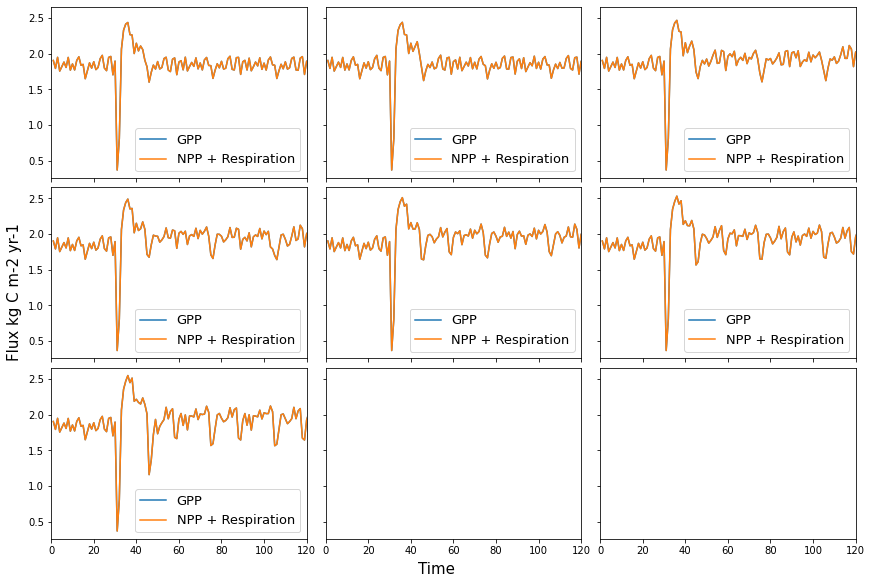

In [5]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    gpp = monthly_to_annual(fates_runs[i].FATES_GPP) * 86400 * 365
    npp = monthly_to_annual(fates_runs[i].FATES_NPP) * 86400 * 365
    resp = monthly_to_annual(fates_runs[i].FATES_AUTORESP) * 86400 * 365
    
    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, gpp, label = 'GPP')  
    axs[i].plot(time, npp + resp, label = 'NPP + Respiration')
    axs[i].legend(fontsize=13)
    axs[i].set_xlim(0,120)

fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)

### 2. NPP = sum of allocation terms

Text(0.5, 0.01, 'Time')

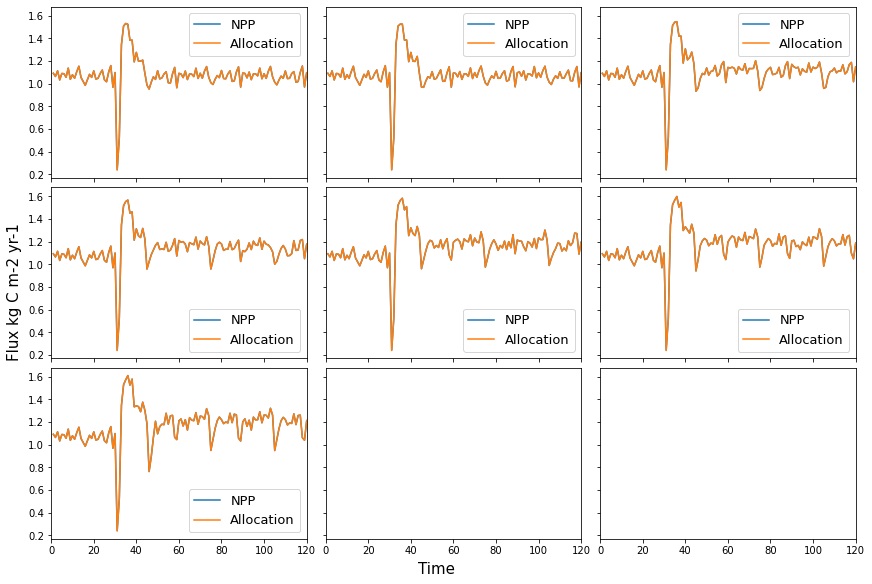

In [6]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    npp = monthly_to_annual(fates_runs[i].FATES_NPP) * 86400 * 365
    
    alloc = (fates_runs[i].FATES_LEAF_ALLOC_CANOPY_SZ  + fates_runs[i].FATES_LEAF_ALLOC_USTORY_SZ + 
             fates_runs[i].FATES_FROOT_ALLOC_CANOPY_SZ  + fates_runs[i].FATES_FROOT_ALLOC_USTORY_SZ + 
             fates_runs[i].FATES_SAPWOOD_ALLOC_CANOPY_SZ  + fates_runs[i].FATES_SAPWOOD_ALLOC_USTORY_SZ + 
             fates_runs[i].FATES_STORE_ALLOC_CANOPY_SZ  + fates_runs[i].FATES_STORE_ALLOC_USTORY_SZ +  
             fates_runs[i].FATES_STRUCT_ALLOC_CANOPY_SZ  + fates_runs[i].FATES_STRUCT_ALLOC_USTORY_SZ + 
             fates_runs[i].FATES_SEED_ALLOC_CANOPY_SZ + fates_runs[i].FATES_SEED_ALLOC_USTORY_SZ) 
    alloc  = alloc.sum(dim='fates_levscls') # kg C m-2 s-1
    alloc = monthly_to_annual(alloc) * 86400 * 365 # kg C m-2 yr-1
    
    
    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, npp, label = 'NPP')  
    axs[i].plot(time, alloc, label = 'Allocation')
    axs[i].legend(fontsize=13)
    axs[i].set_xlim(0,120)

fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)

### 3. Litter fall = mortality + turnover terms

Text(0.5, 0.01, 'Time')

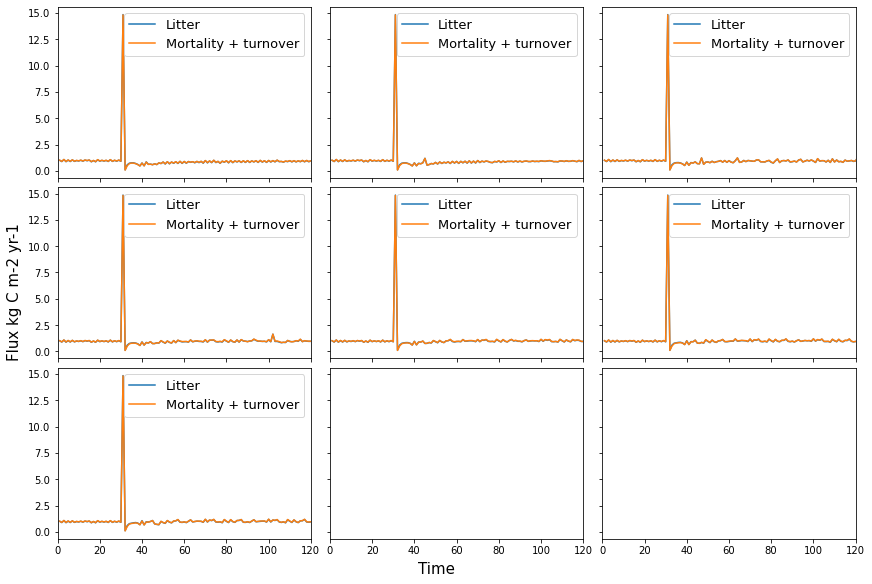

In [7]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    litter_in = monthly_to_annual(fates_runs[i].FATES_LITTER_IN) * 86400 * 365
    
    turn = (fates_runs[i].FATES_LEAFCTURN_CANOPY_SZ + fates_runs[i].FATES_LEAFCTURN_USTORY_SZ + 
            fates_runs[i].FATES_FROOTCTURN_CANOPY_SZ + fates_runs[i].FATES_FROOTCTURN_USTORY_SZ + 
            fates_runs[i].FATES_STORECTURN_CANOPY_SZ + fates_runs[i].FATES_STORECTURN_USTORY_SZ + 
            fates_runs[i].FATES_STRUCTCTURN_CANOPY_SZ + fates_runs[i].FATES_STRUCTCTURN_USTORY_SZ +
            fates_runs[i].FATES_SAPWOODCTURN_CANOPY_SZ + fates_runs[i].FATES_SAPWOODCTURN_USTORY_SZ) 
    turn = turn.sum(dim='fates_levscls')  # kg C m-2 s-1
    turn = monthly_to_annual(turn) * 86400 * 365 # kg C m-2 yr-1
    
    cmort = monthly_to_annual(fates_runs[i].FATES_MORTALITY_CFLUX_PF)
    cmort = cmort.sum(dim='fates_levpft') # kg C m-2 s-1
    cmort = cmort  * 86400 * 365 # kg C m-2 yr-1
    
    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, litter_in, label = 'Litter')  
    axs[i].plot(time, cmort + turn, label = 'Mortality + turnover')
    axs[i].legend(fontsize=13)
    axs[i].set_xlim(0,120)

fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)

#### Cveg = cumulative sum (allocation - loss)

If we include seeds as part of vegetation carbon: 

Vegetation carbon = vegc (trees) + seeds
Inputs = NPP = allocation to leaves, fineroots, sapwood, structure, storage, seeds (note that seed rain is off)
Outputs = mortality + turnover (= litter), seed decay

Text(0.5, 0.01, 'Time')

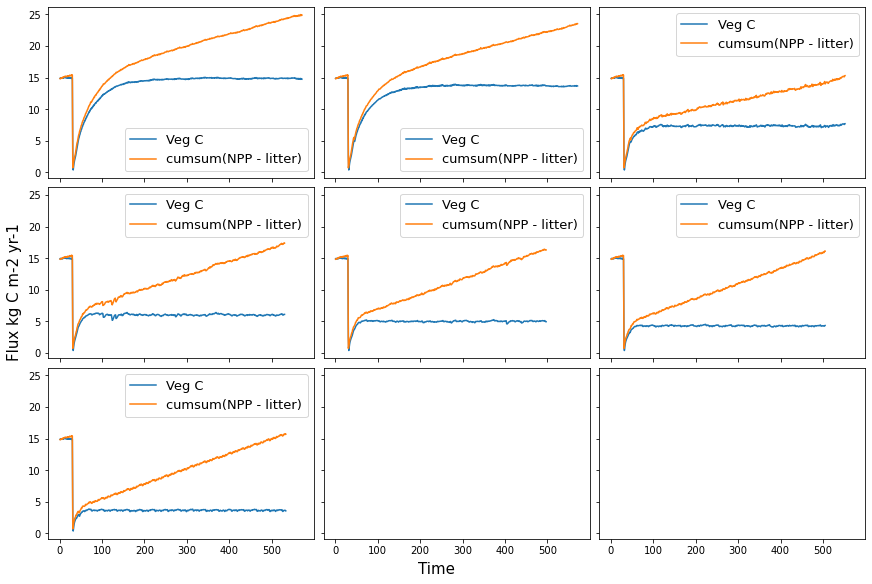

In [8]:
fig1, axs = plt.subplots(nrows=3,ncols=3, figsize=(12,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in range(0,ninst):
    
    # out 
    litter_in = monthly_to_annual(fates_runs[i].FATES_LITTER_IN) * 86400 * 365
    seed_decay = monthly_to_annual(fates_runs[i].FATES_SEED_DECAY_EL.sum(dim='fates_levelem')) * 86400 * 365

    # in
    npp = monthly_to_annual(fates_runs[i].FATES_NPP) * 86400 * 365
    
    # net change
    net = np.cumsum(npp - litter_in - seed_decay) 
    
    # cveg 
    cveg_mon  = fates_runs[i].FATES_VEGC_PF.sum(dim='fates_levpft') + fates_runs[i].FATES_SEED_BANK
    cveg_init = cveg_mon[0]
    cveg = monthly_to_annual(cveg_mon)
    
    nyears = int(len(fates_runs[i].variables['time'])/12)
    time = np.linspace(1,nyears,nyears)
    
    axs[i].plot(time, cveg, label = 'Veg C')  
    axs[i].plot(time, net + cveg_init, label = 'cumsum(NPP - litter)')
    axs[i].legend(fontsize=13)
    #axs[i].set_xlim(0,120)

fig1.supylabel('Flux kg C m-2 yr-1', fontsize=15)
fig1.supxlabel('Time', fontsize=15)